In [1]:
from pathlib import Path
project_root = Path.cwd().resolve().parents[1]
import ray 
ray.shutdown() 
ray.init(runtime_env={"working_dir": project_root})
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytagi import Normalizer
import pytagi.metric as metric
import copy

/opt/miniconda3/envs/canari/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-22 11:56:42,376	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-05-22 11:56:42,994	INFO worker.py:1852 -- Started a local Ray instance.
2025-05-22 11:56:44,699	INFO packaging.py:575 -- Creating a file package for local module '/Users/vuongdai/GitHub/canari'.
2025-05-22 11:56:44,717	WARNING packaging.py:417 -- File /Users/vuongdai/GitHub/canari/.git/objects/92/45ee127ddd1bf42655a9cbd1f0de336db6289d is very large (10.22MiB). Consider adding this file to the 'excludes' list to skip uploading it: `ray.init(..., runtime_env={'excludes': ['/Users/vuongdai/GitHub/canari/.git/objects/92/45ee127ddd1bf42655a9cbd1f0de336db6289d']}

In [2]:
from canari import (
    DataProcess,
    Model,
    SKF,
    ModelOptimizer,
    SKFOptimizer,
    plot_data,
    plot_prediction,
    plot_states,
    plot_skf_states,
)
from canari.component import LocalTrend, LocalAcceleration ,LstmNetwork, WhiteNoise

2025-05-22 11:56:48,182	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
data_file = str(project_root / "data" / "benchmark_data" / "test_4_data.csv")
df = pd.read_csv(data_file, skiprows=1, delimiter=",", header=None)
time = pd.to_datetime(df.iloc[:, 0])
df = df.iloc[:, 1:]
df.index = time
df.index.name = "time"
df.columns = ["crack opening", "water_level", "temp_min", "temp_max"]
lags = [0, 4, 4, 4]
df_lag = DataProcess.add_lagged_columns(df, lags)
output_col = [0]

In [4]:
output_col = [0]
data_processor = DataProcess(
    data=df_lag,
    time_covariates=["week_of_year"],
    train_split=0.23,
    validation_split=0.07,
    output_col=output_col,
)
train_data, validation_data, test_data, all_data = data_processor.get_splits()

In [5]:
param = {
    "look_back_len": [12, 65],
    "sigma_v": [1e-3, 2e-1],
}
num_epoch = 50

In [ ]:
def initialize_model(param, train_data, validation_data):
    model = Model(
        LocalTrend(),
        LstmNetwork(
            look_back_len=param["look_back_len"],
            num_features=17,
            num_layer=1,
            num_hidden_unit=50,
            device="cpu",
            manual_seed=1,
        ),
        WhiteNoise(std_error=param["sigma_v"]),
    )
    model.auto_initialize_baseline_states(train_data["y"][0:52*3])

    # Training
    for epoch in range(num_epoch):
        (mu_validation_preds, std_validation_preds, states) = model.lstm_train(
            train_data=train_data,
            validation_data=validation_data,
        )

        # Unstandardize the predictions
        mu_validation_preds_unnorm = Normalizer.unstandardize(
            mu_validation_preds,
            data_processor.std_const_mean[data_processor.output_col],
            data_processor.std_const_std[data_processor.output_col],
        )

        std_validation_preds_unnorm = Normalizer.unstandardize_std(
            std_validation_preds,
            data_processor.std_const_std[data_processor.output_col],
        )

        validation_obs = data_processor.get_data("validation").flatten()
        validation_log_lik = metric.log_likelihood(
            prediction=mu_validation_preds_unnorm,
            observation=validation_obs,
            std=std_validation_preds_unnorm,
        )

        model.early_stopping(
            evaluate_metric=-validation_log_lik,
            current_epoch=epoch,
            max_epoch=num_epoch,
        )
        model.metric_optim = model.early_stop_metric

        if epoch == model.optimal_epoch:
            mu_validation_preds_optim = mu_validation_preds.copy()
            std_validation_preds_optim = std_validation_preds.copy()
            states_optim = copy.copy(states)

        model.set_memory(states=states, time_step=0)
        if model.stop_training:
            break


    return model, states_optim, mu_validation_preds_optim, std_validation_preds_optim


In [9]:
model_optimizer = ModelOptimizer(
    model=initialize_model,
    param_space=param,
    train_data=train_data,
    validation_data = validation_data,
    num_optimization_trial=50,
)
model_optimizer.optimize()

#  1/50 - Metric: -0.111 - Parameter: {'look_back_len': 41, 'sigma_v': 0.17058047092835715}
#  2/50 - Metric: -0.114 - Parameter: {'look_back_len': 42, 'sigma_v': 0.1580764257516751}
#  3/50 - Metric: -0.059 - Parameter: {'look_back_len': 40, 'sigma_v': 0.08812782742118397}
#  4/50 - Metric: -0.169 - Parameter: {'look_back_len': 29, 'sigma_v': 0.18505230516786145}
#  5/50 - Metric: 0.328 - Parameter: {'look_back_len': 62, 'sigma_v': 0.008213786684172247}
#  6/50 - Metric: -0.505 - Parameter: {'look_back_len': 21, 'sigma_v': 0.1879512640487399}
#  7/50 - Metric: -0.243 - Parameter: {'look_back_len': 24, 'sigma_v': 0.061608509416844204}
#  8/50 - Metric: -0.126 - Parameter: {'look_back_len': 63, 'sigma_v': 0.10055772670648966}
#  9/50 - Metric: -0.168 - Parameter: {'look_back_len': 31, 'sigma_v': 0.14867863821047195}
# 10/50 - Metric: -0.408 - Parameter: {'look_back_len': 36, 'sigma_v': 0.09131673141853425}
# 11/50 - Metric: -0.505 - Parameter: {'look_back_len': 13, 'sigma_v': 0.15290645

2025-05-22 11:58:18,907	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/vuongdai/ray_results/Model_optimizer' in 0.0138s.


# 50/50 - Metric: -0.278 - Parameter: {'look_back_len': 23, 'sigma_v': 0.14305509637446456}
-----
Optimal parameters at trial #49: {'look_back_len': 18, 'sigma_v': 0.14351773733204531}
-----


In [10]:
# Get optimal model
param_optim = model_optimizer.get_best_param()
model_optim, states_optim, mu_validation_preds, std_validation_preds = initialize_model(param_optim, train_data, validation_data)

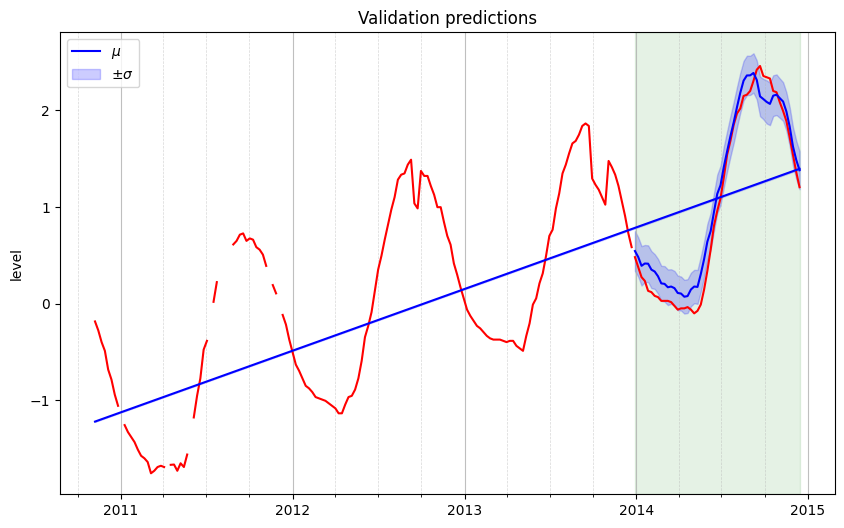

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_data(
    data_processor=data_processor,
    standardization=True,
    plot_test_data=False,
    plot_column=output_col,
    test_label="y",
)
plot_prediction(
    data_processor=data_processor,
    mean_validation_pred=mu_validation_preds,
    std_validation_pred=std_validation_preds,
    validation_label=[r"$\mu$", f"$\pm\sigma$"],
)
plot_states(
    data_processor=data_processor,
    states=states_optim,
    standardization=True,
    states_to_plot=["level"],
    sub_plot=ax,
)
plt.legend()
plt.title("Validation predictions")
plt.show()

In [12]:
model_optim_dict = model_optim.get_dict()

Step #2: Tune parameters for SKF

In [13]:
def initialize_skf(skf_param, model_param: dict):
    norm_model = Model.load_dict(model_param)
    abnorm_model = Model(
        LocalAcceleration(),
        LstmNetwork(),
        WhiteNoise(),
    )
    skf = SKF(
        norm_model=norm_model,
        abnorm_model=abnorm_model,
        std_transition_error=skf_param["std_transition_error"],
        norm_to_abnorm_prob=skf_param["norm_to_abnorm_prob"],
        abnorm_to_norm_prob=1e-1,
        norm_model_prior_prob=0.99,
    )
    return skf

In [14]:
slope_upper_bound = 5e-2
slope_lower_bound = 1e-3
skf_param = {
    "std_transition_error": [1e-6, 1e-3],
    "norm_to_abnorm_prob": [1e-6, 1e-3],
    "slope": [slope_lower_bound, slope_upper_bound],
}

In [15]:
skf_optimizer = SKFOptimizer(
    initialize_skf=initialize_skf,
    param_space=skf_param,
    model_param=model_optim_dict,
    data=train_data,
    num_synthetic_anomaly=50,
    num_optimization_trial=100,
)
skf_optimizer.optimize()

#   1/100 - Metric: 2.016 - Detection rate: 0.08 - False rate: 0.00 - False alarm in train: No - Parameter: {'std_transition_error': 4.015402251287827e-05, 'norm_to_abnorm_prob': 3.58619207931505e-05, 'slope': 0.003235699888990722}
#   2/100 - Metric: 2.009 - Detection rate: 0.00 - False rate: 0.00 - False alarm in train: No - Parameter: {'std_transition_error': 0.00020916961186753837, 'norm_to_abnorm_prob': 8.69950009721963e-05, 'slope': 0.0017246296652935645}
#   3/100 - Metric: 2.220 - Detection rate: 0.00 - False rate: 0.00 - False alarm in train: No - Parameter: {'std_transition_error': 1.0950245856375704e-06, 'norm_to_abnorm_prob': 2.0869217191593176e-06, 'slope': 0.0440467928983829}
#   4/100 - Metric: 2.044 - Detection rate: 0.00 - False rate: 0.00 - False alarm in train: No - Parameter: {'std_transition_error': 2.1607778587159437e-06, 'norm_to_abnorm_prob': 1.079917310156157e-05, 'slope': 0.008799195293188147}
#   5/100 - Metric: 1.120 - Detection rate: 1.00 - False rate: 0.00

2025-05-22 12:00:00,565	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/vuongdai/ray_results/SKF_optimizer' in 0.0237s.


# 100/100 - Metric: 0.689 - Detection rate: 0.62 - False rate: 0.00 - False alarm in train: No - Parameter: {'std_transition_error': 0.00019344945109231316, 'norm_to_abnorm_prob': 0.00013645651405640714, 'slope': 0.013759422054099503}
-----
Optimal parameters at trial #66: {'std_transition_error': 0.0004753184541905799, 'norm_to_abnorm_prob': 1.2526946563231735e-05, 'slope': 0.010373061628631233}
-----


In [16]:
# Get optimal model
skf_optim = skf_optimizer.get_best_model()

In [17]:
filter_marginal_abnorm_prob, states = skf_optim.filter(data=all_data)
filter_marginal_abnorm_prob, states = skf_optim.smoother()

Text(0.5, 1, 'SKF hidden states')

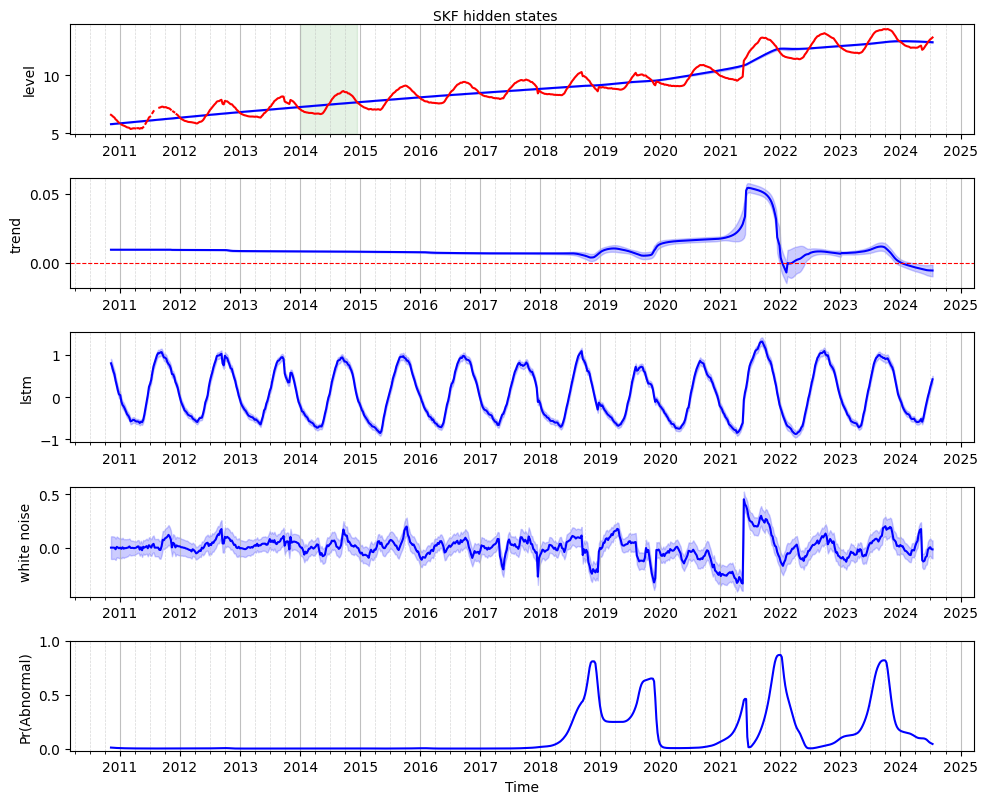

In [18]:
fig, ax = plot_skf_states(
    data_processor=data_processor,
    states=states,
    states_type="smooth",
    states_to_plot=["level", "trend", "lstm", "white noise"],
    model_prob=filter_marginal_abnorm_prob,
)
fig.suptitle("SKF hidden states", fontsize=10, y=1)